## Notebook to explore and demonstrate capabilities for inverse queries:
Note inverse queries are those where model output and certain inputs are known and other inputs are to be estimated

In [1]:
from GPyOpt.methods import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Define your problem
def f(x): return (6*x-2)**2*np.sin(12*x-4)

def errf(x, t=0): 
    fval = f(x)
    return np.abs(fval-t)

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]

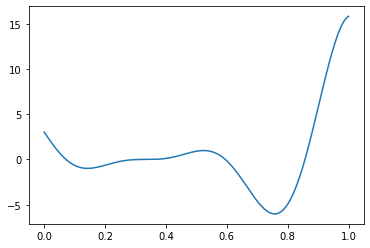

In [3]:
xval = np.linspace(0, 1,200)
plt.plot(xval, f(xval))
#plt.plot(xval, errf(xval))

type of acquisition function to use. 
- ‘EI’, expected improvement. 
- ‘EI_MCMC’, integrated expected improvement (requires GP_MCMC model). 
- ‘MPI’, maximum probability of improvement. 
- ‘MPI_MCMC’, maximum probability of improvement (requires GP_MCMC model). 
- ‘LCB’, GP-Lower confidence bound. 
- ‘LCB_MCMC’, integrated GP-Lower confidence bound (requires GP_MCMC model).

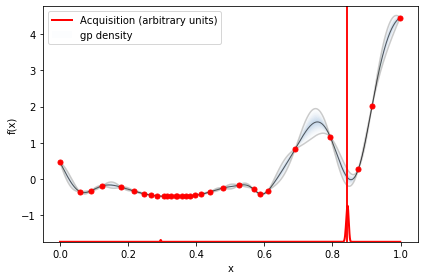

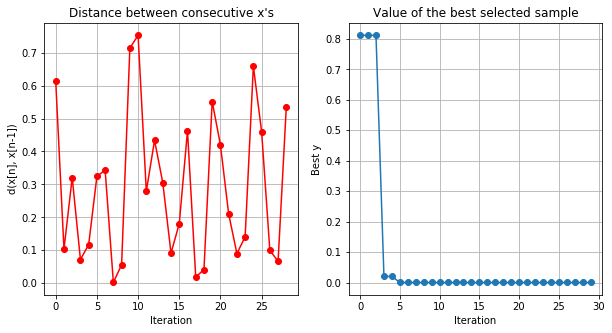

array([0.34107712])

In [4]:
# --- Solve your problem
myBopt = BayesianOptimization(f=errf, domain=domain, acquisition_type='EI')
myBopt.run_optimization(max_iter=25)
myBopt.plot_acquisition()
myBopt.plot_convergence()
myBopt.x_opt

In [5]:
myBopt.X[myBopt.Y<0.00001]

array([], dtype=float64)

## Explore Tf model

In [6]:
import tensorflow as tf
from tensorflow.python import autograph as ag

In [7]:
import sys
sys.path.insert(1, '../kchain/')
from kChain import kChainModel as kc

In [8]:
import requests
#URL to interact with build
url_build = 'http://localhost:12345/darpa/aske/kchain/build'

#URL to interact with evaluate service
url_append = 'http://localhost:12345/darpa/aske/kchain/append'

#URL to interact with evaluate service
url_evaluate = 'http://localhost:12345/darpa/aske/kchain/evaluate'

In [9]:
inputPacket = {
                  "inputVariables": [
                    {
                        "name": "gamma",
                        "type": "double",
                        "value": "1.4"
                    },
                    {
                        "name": "R",
                        "type": "double",
                        "value": "286.0"
                    },
                    {
                        "name": "theta",
                        "type": "double",
                        "value": "3056.0"
                    },
                    {
                      "name": "T",
                      "type": "double"
                    }
                  ],
                  "outputVariables": [
                    {
                      "name": "a",
                      "type": "double"
                    }
                  ],
                   "equationModel" : "a = tf.math.pow(R * T *  (  1 + ( gamma-1 ) / ( 1 + ( gamma-1 ) *  ( tf.math.pow( theta/T,2) *  tf.math.exp( theta/T ) /  tf.math.pow( tf.math.exp( theta/T ) - 1,2 ))  ) ), 1/2)",
                   "modelName" : "speedOfSound"
                 }
r = requests.post(url_build, json=inputPacket)
r.json()

{'metagraphLocation': '../models/speedOfSound',
 'modelType': 'Physics',
 'trainedState': 0}

build model

evaluate model with arbitrarily chosen inputs

integrate evaluate model call with residual error function

call error function via BayesOpt

## Single unknown input case

In [10]:
def computeSoS(T):
    evalPacket = {
      "inputVariables": [
        {
          "name": "T",
          "type": "double",
          "value": str(T)
        }
      ],
      "modelName": "SpeedOfSound",
      "outputVariables": [
        {
          "name": "a",
          "type": "double"
        }
      ]
    }
    #print(evalPacket)
    r = requests.post(url_evaluate, json=evalPacket)
    #print(r.json())
    rval = float(r.json()['outputVariables'][0]['value'][1:-1])
    return rval

In [11]:
def errC(x, t, model): 
    fval = model(x)
    return np.abs(fval-t)

In [12]:
domain = [{'name': 'T', 'type': 'continuous', 'domain': (100,500)}]
fx = lambda x : errC(x[0], t = 380.0, model = computeSoS)
MAXITER = 35

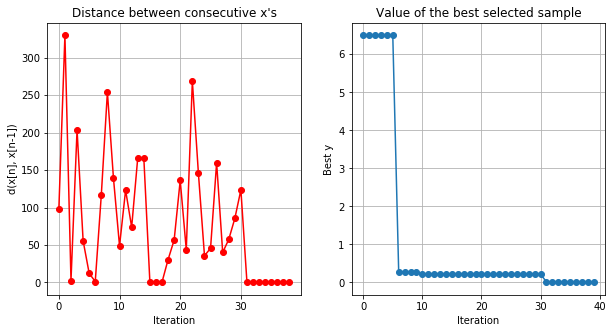

[361.25939555]
0.0013400000000274304


In [13]:
myBopt = BayesianOptimization(f=fx, domain=domain, acquisition_type='EI')
myBopt.run_optimization(max_iter=MAXITER)
myBopt.plot_convergence()
print(myBopt.x_opt)
print(myBopt.fx_opt)

## Multiple Unknown Input Case 1:

In [14]:
def computeSoS2(T, gamma):
    evalPacket = {
      "inputVariables": [
        {
          "name": "T",
          "type": "double",
          "value": str(T)
        },
        {
            "name": "gamma",
            "type": "double",
            "value": str(gamma)
        }
      ],
      "modelName": "SpeedOfSound",
      "outputVariables": [
        {
          "name": "a",
          "type": "double"
        }
      ]
    }
    #print(evalPacket)
    r = requests.post(url_evaluate, json=evalPacket)
    #print(r.json())
    rval = float(r.json()['outputVariables'][0]['value'][1:-1])
    return rval

In [15]:
def errC2(x1, x2, t, model): 
    fval = model(x1, x2)
    return np.abs(fval-t)

In [16]:
domain = [{'name': 'T', 'type': 'continuous', 'domain': (100,500)},
          {'name': 'gamma', 'type': 'continuous', 'domain': (1.3,1.5)}]
fx = lambda x : errC2(x[0][0], x[0][1], t = 380.0, model = computeSoS2)
MAXITER = 35

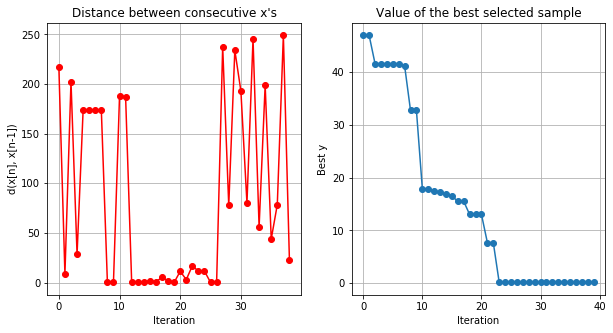

[337.36596364   1.5       ]
0.13240000000001828


In [17]:
myBopt = BayesianOptimization(f = fx, domain=domain, acquisition_type='EI')
myBopt.run_optimization(max_iter=MAXITER)
myBopt.plot_convergence()
print(myBopt.x_opt)
print(myBopt.fx_opt)

## Multiple Unknown Input Case 2:

In [31]:
def computeSoS2(X):
    evalPacket = {
      "inputVariables": [
        {
          "name": "T",
          "type": "double",
          "value": str(X[0])
        },
        {
            "name": "gamma",
            "type": "double",
            "value": str(X[1])
        }
      ],
      "modelName": "SpeedOfSound",
      "outputVariables": [
        {
          "name": "a",
          "type": "double"
        }
      ]
    }
    #print(evalPacket)
    r = requests.post(url_evaluate, json=evalPacket)
    #print(r.json())
    rval = float(r.json()['outputVariables'][0]['value'][1:-1])
    return rval

In [32]:
def errC(x, t, model): 
    fval = model(x)
    return np.abs(fval-t)

In [33]:
#name doesnt matter in domain as long as ordering is correct
domain = [{'name': 'T', 'type': 'continuous', 'domain': (100,500)},
          {'name': 'gamma', 'type': 'continuous', 'domain': (1.3,1.5)}]
fx = lambda x : errC(x[0], t = 380.0, model = computeSoS2)
MAXITER = 35

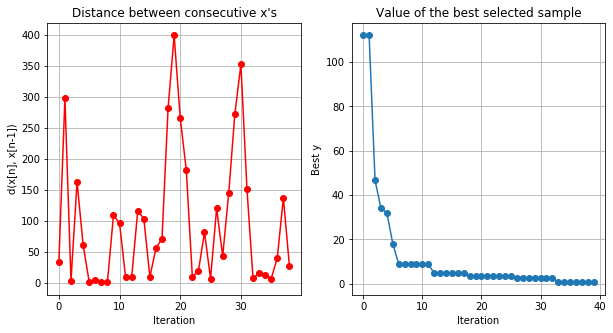

[336.1743451   1.5      ]
0.5321400000000267


In [34]:
myBopt = BayesianOptimization(f = fx, domain=domain, acquisition_type='EI')
myBopt.run_optimization(max_iter=MAXITER)
myBopt.plot_convergence()
print(myBopt.x_opt)
print(myBopt.fx_opt)

## Multiple Known and Unknown Input Case 1:

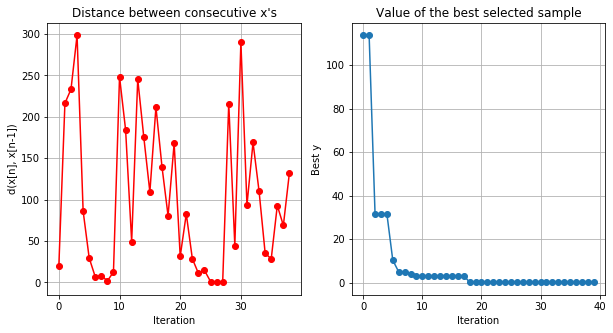

[361.15227293   1.4       ]
0.05707000000001017


In [38]:
context = {'gamma':1.4}

myBopt = BayesianOptimization(f = fx, domain=domain, acquisition_type='EI')
myBopt.run_optimization(max_iter=MAXITER, context=context)
myBopt.plot_convergence()
print(myBopt.x_opt)
print(myBopt.fx_opt)